In [5]:
import pandas as pd
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

import re

from utils import (
    split_dataset,
    plot_classification_results,
    return_top_5,
    plot_confidence_distribution
)

# from modules.db import TeradataDatabase

from constants import (
    FULL_DATASET_PATH,
    FULL_TRAIN_DATASET_PATH,
    FULL_TEST_DATASET_PATH,
    FULL_EMBEDDING_MODEL_OUTPUT_DATASET_PATH,
    TFIDF_CLASSIFIER_CONFIG_PATH,
    EMBEDDING_SVM_CONFIG_PATH,
    ENSEMBLE_CONFIG_PATH,
    FULL_ENSEMBLE_MODEL_OUTPUT_DATASET_PATH,
    EMBEDDING_CLASSIFIER_CONFIG_PATH,
    FULL_TFIDF_SIMILARITY_OUTPUT_DATASET_PATH,
    CLASS_ONLY_CLASSIFIER,
    GPC_PATH
)

In [6]:
df_gpc = pd.read_csv(GPC_PATH)
df_gpc.head()

,SegmentCode,SegmentTitle,SegmentDefinition,FamilyCode,FamilyTitle,FamilyDefinition,ClassCode,ClassTitle,ClassDefinition,BrickCode,BrickTitle,BrickDefinition_Includes,BrickDefinition_Excludes,AttributeCode,AttributeTitle,AttributeDefinition,AttributeValueCode,AttributeValueTitle,AttributeValueDefinition
0,70000000,Arts/Crafts/Needlework,All products that are used to any creative act...,70010000,Arts/Crafts/Needlework Supplies,All products that are used to any creative act...,70010100,Artists Painting/Drawing Supplies,Includes any products that may be described/ob...,10001674,Artists Brushes/Applicators,Includes any products that can be described/ob...,Specifically excludes Household Paint Brushes ...,20001337.0,Type of Artists Brush/Applicator,"Indicates, with reference to the product brand...",30008491.0,ARTISTS BLENDER/FINISHING BRUSH,NaN
1,70000000,Arts/Crafts/Needlework,All products that are used to any creative act...,70010000,Arts/Crafts/Needlework Supplies,All products that are used to any creative act...,70010100,Artists Painting/Drawing Supplies,Includes any products that may be described/ob...,10001679,Artists Canvas/Pre-primed Boards,Includes any products that can be described/ob...,Excludes products such as Artists Palettes and...,20001342.0,Type of Artists Canvas/Pre-primed Board,"Indicates, with reference to the product brand...",30008514.0,ARTISTS CANVAS ROLL,NaN
2,70000000,Arts/Crafts/Needlework,All products that are used to any creative act...,70010000,Arts/Crafts/Needlework Supplies,All products that are used to any creative act...,70010100,Artists Painting/Drawing Supplies,Includes any products that may be described/ob...,10005372,Artists Drawing Boards,Includes any products that can be described/ob...,Excludes products such as artists canvasses or...,20002304.0,Desktop/Freestanding,"Indicates, with reference to the product brand...",30007587.0,DESKTOP,NaN
3,70000000,Arts/Crafts/Needlework,All products that are used to any creative act...,70010000,Arts/Crafts/Needlework Supplies,All products that are used to any creative act...,70010100,Artists Painting/Drawing Supplies,Includes any products that may be described/ob...,10001681,Artists Easels,Includes any products that can be described/ob...,Excludes products such as Frames and Stationer...,20001344.0,Type of Artists Easel,"Indicates, with reference to the product brand...",30008521.0,FREESTANDING EASEL,NaN
4,70000000,Arts/Crafts/Needlework,All products that are used to any creative act...,70010000,Arts/Crafts/Needlework Supplies,All products that are used to any creative act...,70010100,Artists Painting/Drawing Supplies,Includes any products that may be described/ob...,10001678,Artists Painting Surface Agents,Includes any products that can be described/ob...,Specifically excludes all types of Paints clas...,20001341.0,Type of Artists Surface Agent,"Indicates, with reference to the product brand...",30008509.0,ARTISTS CANVAS PRIMER,NaN


In [22]:
grouped = df_gpc[df_gpc["SegmentTitle"].isin(["Computing", "Clothing"])].groupby("SegmentTitle")
grouped["FamilyTitle"].apply(lambda x: x.drop_duplicates().tolist()).tolist()

[['Activewear',
  'Clothing',
  'Protective Wear',
  'Sleepwear',
  'Swimwear',
  'Underwear'],
 ['Computers/Video Games']]

In [6]:
df = pd.read_csv(FULL_DATASET_PATH)
df.head()

,Unnamed: 0,product_name,description,segment,family,class,brick,source,text,dedup_key
0,0,Sterling Silver Angel Charm,This little angel charm is just heavenly,Personal Accessories,Personal Accessories,Jewellery,NaN,MWPD_FULL,sterling silver angel charm,sterling silver angel charm
1,1,HP Pavilion xi . cm (�) IPS Monitor,"Share photos, videos, and games with everyone ...",Computing,Computers/Video Games,Computer/Video Game Peripherals,NaN,MWPD_FULL,hp pavilion xi . cm ips monitor,hp pavilion xi cm ips monitor
2,2,East Carolina Pirates Ladies Personalized Bask...,Feel like a bona fide member of East Carolina ...,Clothing,Clothing,Upper Body Wear/Tops,NaN,MWPD_FULL,east carolina pirates ladies personalized bask...,east carolina pirates ladies personalized bask...
3,3,"Tekonsha P Electric Brake Control, - Trailer ...",Receive free shipping on this item. Enter coup...,Automotive,Automotive Accessories and Maintenance,Automotive Maintenance/Repair,NaN,MWPD_FULL,tekonsha p electric brake control - trailer axles,tekonsha p electric brake control trailer axles
4,4,RN-XV WiFly Module - Wire Antenna,Description: The RN-XV module by Roving Networ...,Electrical Supplies,Electronic Communication Components,Electronic Communication Components,NaN,MWPD_FULL,rn-xv wifly module - wire antenna,rn xv wifly module wire antenna


In [9]:
df.info()

In [8]:
for col in ["segment", "family", "class"]:
    print(f"Unique {col}: {df[col].nunique()}")

In [3]:
def clean(text: str) -> str:
    text = text.lower()
    text = re.sub(r"[^\w\s]", " ", text)

    return " ".join(text.strip().split())

In [4]:
df_train = pd.read_csv(FULL_TRAIN_DATASET_PATH)

df_train["product_name"] = df_train["product_name"].astype(str)

In [5]:
df_test = pd.read_csv(FULL_TEST_DATASET_PATH)

df_test["product_name"] = df_test["product_name"].astype(str)

In [10]:
X_train = df_train["product_name"].tolist()
y_train = df_train["class"].tolist()

In [11]:
X_test = df_test["product_name"].tolist()
segments = df_test["segment"].tolist()
families = df_test["family"].tolist()
classes = df_test["class"].tolist()

# TF-IDF with SVM

In [12]:
model = load_tfidf_classifier_model(TFIDF_CLASSIFIER_CONFIG_PATH)

In [13]:
model.fit(X_train, y_train)

In [15]:
y_pred = model.predict(X_test)

In [16]:
class_to_segment = df_train.set_index("class")["segment"].to_dict()
class_to_family = df_train.set_index("class")["family"].to_dict()

pred_segments = [class_to_segment.get(c, None) for c in y_pred]
pred_families = [class_to_family.get(c, None) for c in y_pred]

In [17]:
accuracy_score(segments, pred_segments)

0.9667695540815656

In [18]:
accuracy_score(families, pred_families)

0.9502200039403691

In [19]:
accuracy_score(classes, y_pred)

0.9431930124121626

In [20]:
model.save()

# Embedding With SVM

In [26]:
model = load_embedding_svm_model(EMBEDDING_SVM_CONFIG_PATH)

In [8]:
model.fit(X_train, y_train)

Batches:   0%|          | 0/1904 [00:00<?, ?it/s]

In [9]:
y_pred = model.predict(X_test)

Batches:   0%|          | 0/476 [00:00<?, ?it/s]

In [10]:
pred_segments = [pred[0] for pred in y_pred]
pred_families = [pred[1] for pred in y_pred]
pred_classes = [pred[2] for pred in y_pred]

In [11]:
accuracy_score(segments, pred_segments)

0.9326241134751773

In [12]:
accuracy_score(families, pred_families)

0.9061597058050959

In [13]:
accuracy_score(classes, pred_classes)

0.8815996847911741

In [ ]:
model.save()

# Embedding model

In [ ]:
embed_clf = load_embedding_classifier_model(EMBEDDING_CLASSIFIER_CONFIG_PATH)

In [ ]:
df = pd.read_csv(FULL_EMBEDDING_MODEL_OUTPUT_DATASET_PATH)

In [5]:
df["pred_segment"] = df["pred_segment"].apply(clean)
df["pred_family"] = df["pred_family"].apply(clean)
df["pred_class"] = df["pred_class"].apply(clean)

In [6]:
accuracy_score(df["segment"].tolist(), df["pred_segment"].tolist())

0.3044391909640137

In [7]:
accuracy_score(df["family"].tolist(), df["pred_family"].tolist())

0.11583924349881797

In [8]:
accuracy_score(df["class"], df["pred_class"])

0.050170738114000524

## Test TF-IDF Similiraity

In [2]:
results = pd.read_csv(FULL_TFIDF_SIMILARITY_OUTPUT_DATASET_PATH)

In [3]:
accuracy_score(results["segment"], results["pred_segment"])

0.3619885729296644

In [4]:
accuracy_score(results["family"], results["pred_family"])

0.16050436724239836

In [5]:
accuracy_score(results["class"], results["pred_class"])

0.10829447691600447

# Test Ensemble Pipeline

In [2]:
df = pd.read_csv(FULL_ENSEMBLE_MODEL_OUTPUT_DATASET_PATH)

In [3]:
accuracy_score(df["segment"].tolist(), df["pred_segment"].tolist())

0.9583661675860258

In [4]:
accuracy_score(df["family"].tolist(), df["pred_family"].tolist())

0.9506829524560021

In [5]:
accuracy_score(df["class"], df["pred_class"])

0.9359075387444181

# Perofarmance Results

In [9]:
tfidf_simliraity_results = pd.read_csv(FULL_TFIDF_SIMILARITY_OUTPUT_DATASET_PATH)

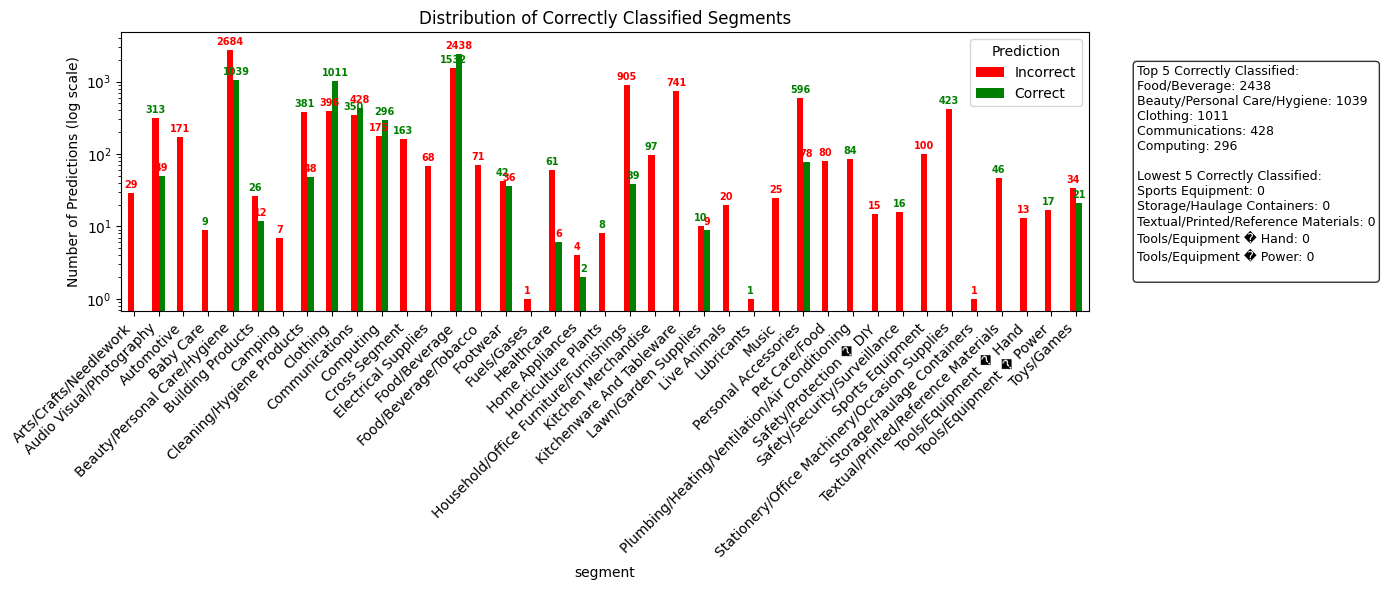

In [17]:
plot_classification_results(tfidf_simliraity_results, "segment")

In [ ]:
plot_classification_results(tfidf_simliraity_results, "family")

In [ ]:
plot_classification_results(tfidf_simliraity_results, "class")

# Classifier

In [28]:
classifier_results = pd.read_csv(CLASS_ONLY_CLASSIFIER)

In [ ]:
classifier_results[classifier_results["segment"].str.contains("Text")][["segment", "pred_segment"]]

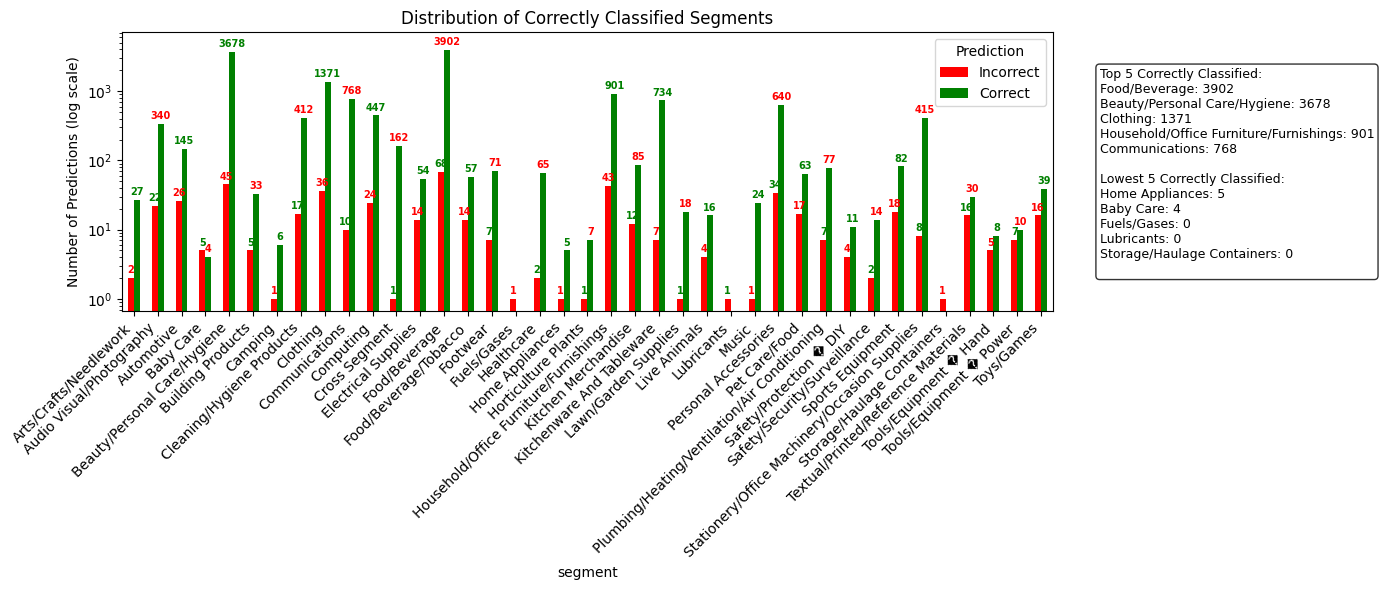

In [41]:
plot_classification_results(classifier_results, "segment")

In [ ]:
plot_classification_results(classifier_results, "family")

In [ ]:
plot_classification_results(classifier_results, "class")

# Embedding Model

In [36]:
embedding_model_results = pd.read_csv(FULL_EMBEDDING_MODEL_OUTPUT_DATASET_PATH)

In [44]:
embedding_model_results[embedding_model_results["segment"].str.contains("Fu")][["segment", "pred_segment"]]

,segment,pred_segment
11,Household/Office Furniture/Furnishings,Household/Office Furniture/Furnishings
13,Household/Office Furniture/Furnishings,Cleaning/Hygiene Products
54,Household/Office Furniture/Furnishings,Household/Office Furniture/Furnishings
58,Household/Office Furniture/Furnishings,Tool Storage/Workshop Aids
66,Household/Office Furniture/Furnishings,Tool Storage/Workshop Aids
...,...,...
15176,Household/Office Furniture/Furnishings,Tool Storage/Workshop Aids
15178,Household/Office Furniture/Furnishings,Household/Office Furniture/Furnishings
15181,Household/Office Furniture/Furnishings,Lawn/Garden Supplies
15182,Household/Office Furniture/Furnishings,Household/Office Furniture/Furnishings


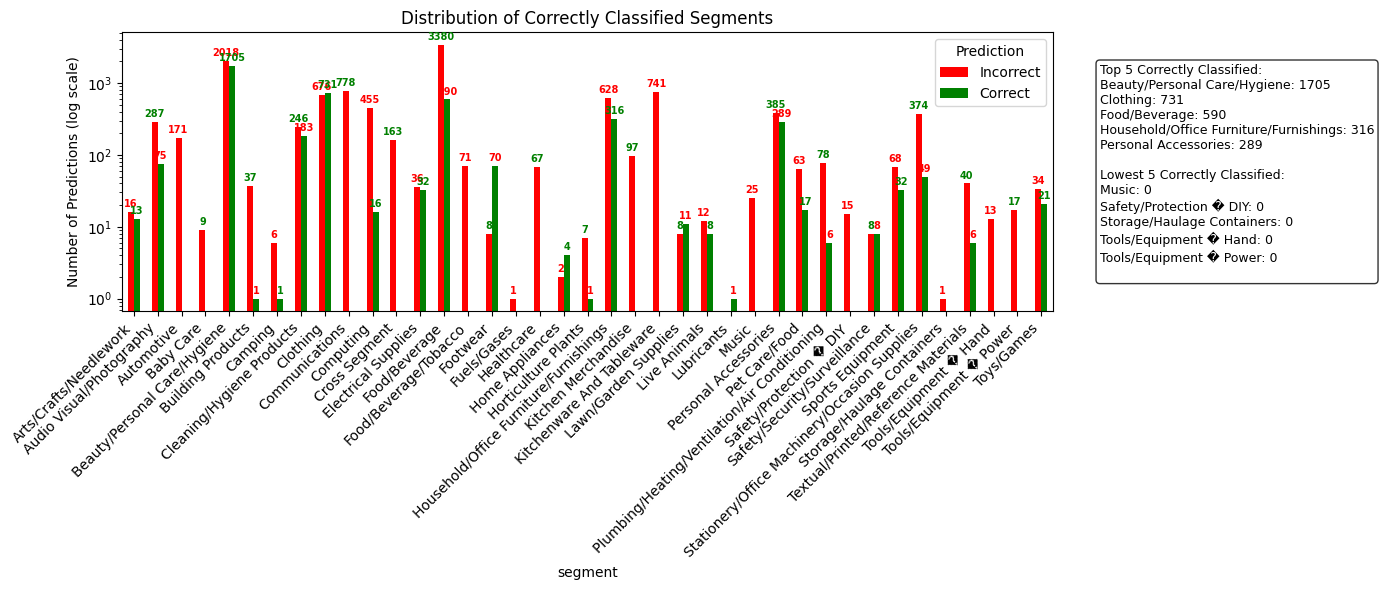

In [13]:
plot_classification_results(embedding_model_results, "segment")

In [ ]:
plot_classification_results(embedding_model_results, "family")

In [ ]:
plot_classification_results(embedding_model_results, "class")

# Ensemble Results

In [2]:
df = pd.read_csv(FULL_ENSEMBLE_MODEL_OUTPUT_DATASET_PATH)

In [3]:
df["is_correct"] = df.apply(lambda x: x["segment"]==x["pred_segment"], axis=1)

In [4]:
df_correct = df[df["is_correct"]==True]
df_incorrect = df[df["is_correct"]==False]
plot_confidence_distribution(df_correct, "hi.jpg")

In [3]:
plot_classification_results(df, "segment", "goodbye.jpg")

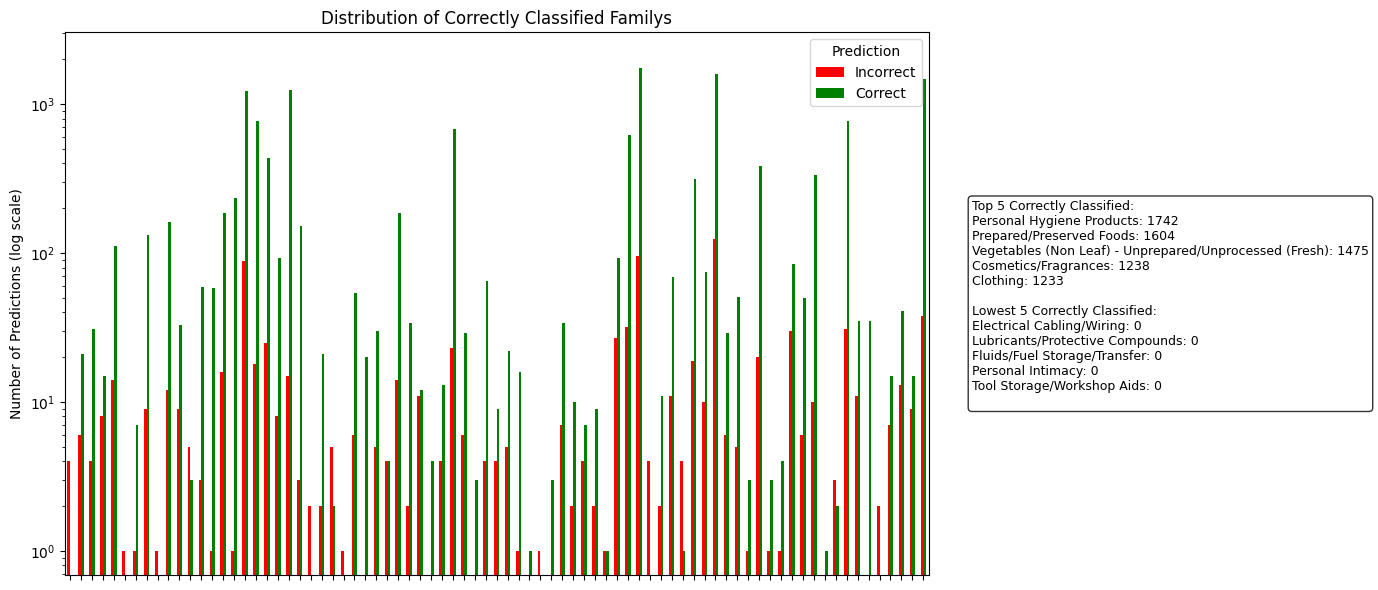

In [14]:
plot_classification_results(df, "family")

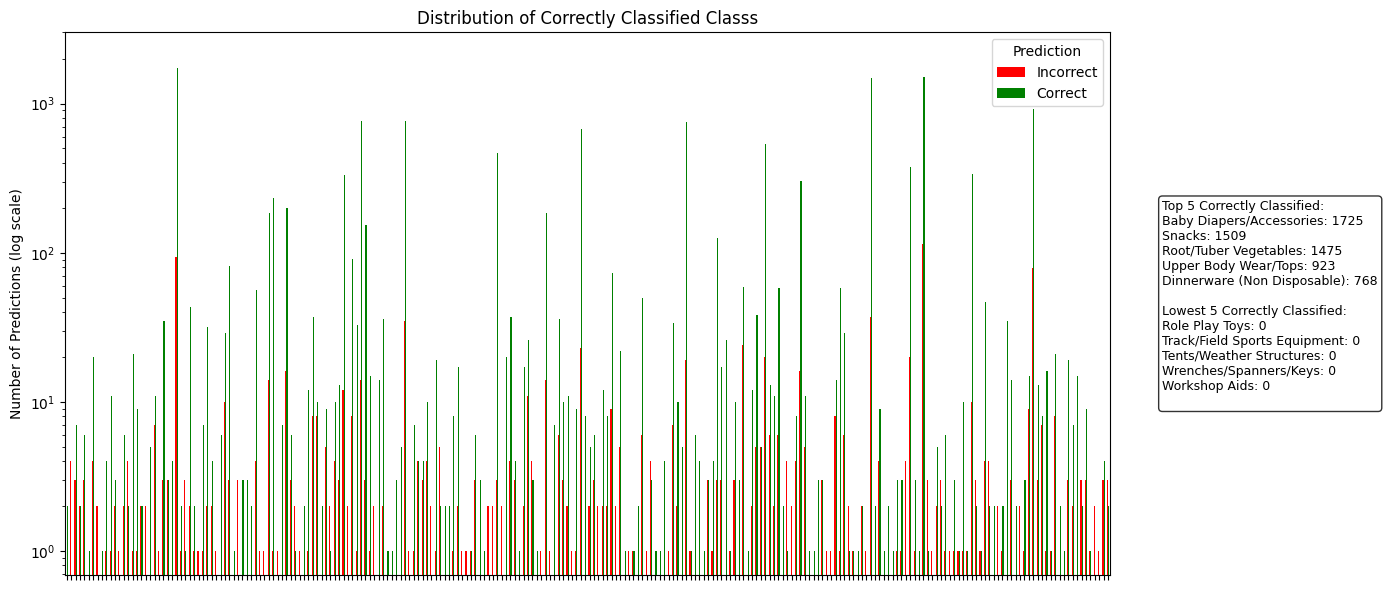

In [15]:
plot_classification_results(df, "class")

In [5]:
df.head()

,Unnamed: 0,product_name,description,segment,family,class,brick,source,text,dedup_key,pred_segment,pred_family,pred_class
0,30904,Neelam Foodland Special Low Fat Schezwan Chakl...,NaN,Food/Beverage,Prepared/Preserved Foods,Snacks,NaN,JIO_MART,neelam foodland special low fat schezwan chakli g,neelam foodland special low fat schezwan chakli g,['Food/Beverage'],['Prepared/Preserved Foods'],['Snacks']
1,75917,Dynore Stainless Steel Black Matte Cocktail Sh...,NaN,Kitchenware And Tableware,Tableware,Dinnerware (Non Disposable),NaN,JIO_MART,dynore stainless steel black matte cocktail sh...,dynore stainless steel black matte cocktail sh...,['Kitchenware and Tableware'],['Tableware'],['Dinnerware (Non Disposable)']
2,58858,Cuteably Navy Blue Born Baby Swing Khoya Cradl...,NaN,Beauty/Personal Care/Hygiene,Personal Hygiene Products,Baby Diapers/Accessories,NaN,JIO_MART,cuteably navy blue born baby swing khoya cradl...,cuteably navy blue born baby swing khoya cradl...,['Beauty/Personal Care/Hygiene'],['Personal Hygiene Products'],['Baby Diapers/Accessories']
3,157423,Zebronics ZEB-LAAS V/W Laptop Adapter with LED...,NaN,Computing,Computers/Video Games,Computers,NaN,JIO_MART,zebronics zeb-laas v/w laptop adapter with led...,zebronics zeb laas v w laptop adapter with led...,['Computing'],['Computers/Video Games'],['Computers']
4,123333,Indian Art Villa Pure Brass Stand/Pillar Diya ...,NaN,Stationery/Office Machinery/Occasion Supplies,Stationery/Office Machinery/Occasion Supplies ...,Stationery/Office Machinery/Occasion Supplies ...,NaN,JIO_MART,indian art villa pure brass stand/pillar diya ...,indian art villa pure brass stand pillar diya ...,['Stationery/Office Machinery/Occasion Supplies'],['Stationery/Office Machinery/Occasion Supplie...,['Stationery/Office Machinery/Occasion Supplie...


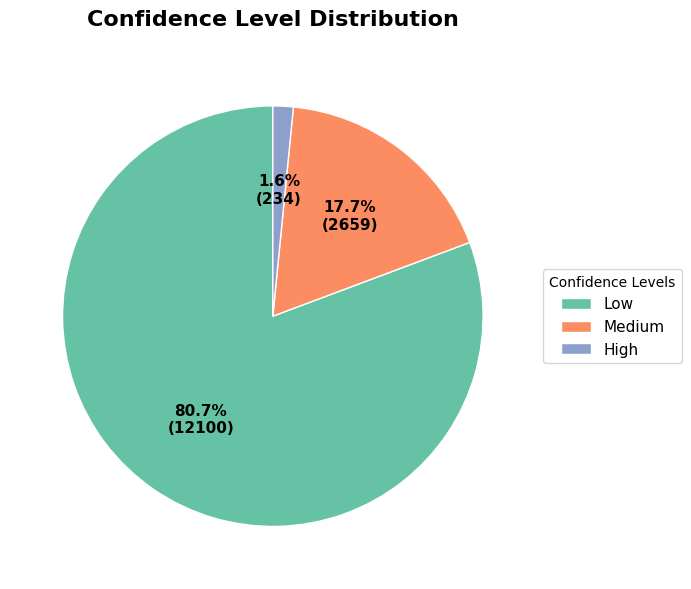

In [6]:
counts = df["confidence_level"].value_counts()

colors = plt.cm.Set2(range(len(counts)))

fig, ax = plt.subplots(figsize=(7, 7))
wedges, texts, autotexts = ax.pie(
    counts,
    labels=None,
    autopct=lambda p: f"{p:.1f}%\n({int(round(p*sum(counts)/100.0))})",
    startangle=90,
    colors=colors,
    wedgeprops={'edgecolor': 'white', 'linewidth': 1},
    textprops={'fontsize': 11, 'weight': 'bold', 'color': 'black'}
)

ax.legend(
    wedges,
    counts.index,
    title="Confidence Levels",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1),
    fontsize=11
)

ax.set_title("Confidence Level Distribution", fontsize=16, weight="bold", pad=20)

plt.tight_layout()
plt.show()

In [11]:
top5_segments = return_top_5(df, "segment")
families_per_segment = df[df["segment"].isin(top5_segments)].groupby("segment")["family"].unique().tolist()
classes_per_segment = df[df["segment"].isin(top5_segments)].groupby("segment")["class"].unique().tolist()
families_per_segment, classes_per_segment

([array(['Cosmetics/Fragrances', 'Hair Products',
         'Personal Hygiene Products', 'Skin Products', 'Maternity Products',
         'Beauty/Personal Care/Hygiene Variety Packs', 'Personal Intimacy',
         'Body Products'], dtype=object),
  array(['Clothing', 'Protective Wear', 'Underwear', 'Activewear',
         'Sleepwear'], dtype=object),
  array(['Vegetables (Non Leaf) - Unprepared/Unprocessed (Fresh)',
         'Prepared/Preserved Foods', 'Bread/Bakery Products',
         'Seasonings/Preservatives/Extracts',
         'Fruits/Vegetables/Nuts/Seeds Prepared/Processed',
         'Confectionery/Sugar Sweetening Products',
         'Fruits/Vegetables Fresh Cut', 'Cereal/Grain/Pulse Products',
         'Beverages', 'Milk/Butter/Cream/Yogurts/Cheese/Eggs/Substitutes',
         'Oils/Fats Edible'], dtype=object),
  array(['Household/Office Furnishings', 'Ornamental Furnishings',
         'Household/Office Furniture', 'Baby Furnishings'], dtype=object),
  array(['Tableware', 'Kitchen

In [ ]:
counts_confidence = (
    df[df["segment"].isin(top5_segments)]
    .groupby(["segment", "confidence_level"])
    .size()
    .unstack(fill_value=0)
)

counts_confidence


In [ ]:
top5_segments = return_top_5(df, "family")

counts_confidence = (
    df[df["family"].isin(top5_segments)]
    .groupby(["family", "confidence_level"])
    .size()
    .unstack(fill_value=0)
)

print(counts_confidence)


In [ ]:
top5_segments = return_top_5(df, "class")

counts_confidence = (
    df[df["class"].isin(top5_segments)]
    .groupby(["class", "class"])
    .size()
    .unstack(fill_value=0)
)

counts_confidence

In [12]:
results = {}

for level in ["segment", "family", "class"]:
    col_true = level
    col_pred = f"pred_{level}"
    df[f"correct_{level}"] = df[col_true] == df[col_pred]

    summary = (
        df.groupby([f"correct_{level}", "confidence_level"])
        .size()
        .unstack(fill_value=0)
        .rename(index={True: "Correct", False: "Incorrect"})
    )
    
    results[level] = summary

for level, table in results.items():
    print(f"\n=== {level.upper()} LEVEL ===")
    print(table)
